In [7]:
import json, glob, os, random
from math import log as ln
import cv2
import numpy as np
import visualization as vis

def IOU(xminA, yminA, xmaxA, ymaxA, xminB, yminB, xmaxB, ymaxB): # VOC
    inter = max(0,min(ymaxA,ymaxB)-max(yminA,yminB)) * max(0,min(xmaxA,xmaxB)-max(xminA,xminB))
    areaA = (ymaxA-yminA) * (xmaxA-xminA)
    areaB = (ymaxB-yminB) * (xmaxB-xminB)
    return inter / (areaA+areaB-inter) if (areaA+areaB-inter)!=0 else 0

class EnsemblingCompare:
    def __init__(self, imgFolder, pdPath1, pdPath2, classL=None, outputPath="./compare.json"):
        self.imgPathL     = sorted([ os.path.abspath(imgPath) for imgPath in glob.glob(imgFolder+"/*.jpg")])
        self.h, self.w, _ = cv2.imread( self.imgPathL[0] ).shape # 720*1280
        self.D = { imgPath:{"m1":[],"m2":[]} for imgPath in self.imgPathL }
        self.loadYoloFormat( pdPath1, pdPath2 )
        print( f"self.h={self.h}, self.w={self.w}, len(self.D)={len(self.D)}" )
        print( f"self.D[next(iter(self.D))] = {self.D[next(iter(self.D))]}" )
        self.classL     = classL
        self.outputPath = outputPath
    
    def loadYoloFormat(self, pdPath1, pdPath2, confThreshold=0.75): # cid, cx, cy, w, h, conf
        if ".tmp.json" in os.listdir():
            self.D = json.load(open(".tmp.json","r"))
            return
        pdPathL1 = sorted(glob.glob(f"{pdPath1}/*.txt"))
        pdPathL2 = sorted(glob.glob(f"{pdPath2}/*.txt"))
        assert len(self.imgPathL)==len(pdPathL1)==len(pdPathL2), (len(self.imgPathL),len(pdPathL1),len(pdPathL2))
        for imgPath,pdPath1,pdPath2 in zip(self.imgPathL,pdPathL1,pdPathL2):
            assert os.path.basename(pdPath1)==os.path.basename(pdPath2)
            for pdPath,model in [(pdPath1,'m1'), (pdPath2,'m2')]:
                for line in open(pdPath,"r").readlines():
                    cid, cx, cy, w, h, conf = line.split(" ")
                    if float(conf)>confThreshold:
                        xmin = int((float(cx)-float(w)/2)*self.w)
                        ymin = int((float(cy)-float(h)/2)*self.h)
                        xmax = int((float(cx)+float(w)/2)*self.w)
                        ymax = int((float(cy)+float(h)/2)*self.h)
                        self.D[imgPath][model].append( [int(cid), xmin, ymin, xmax, ymax, float(conf)] )

    def visPredict(self, mode, num=1, confThreshold=0.75):
        if mode=="random":
            keyL = [ imgPath for imgPath in self.D ]
            random.shuffle(keyL)
        elif mode=="sortedSingle":
            keyL = [ imgPath for _,imgPath in self.sortedSingle1[:num//2]+self.sortedSingle2[:num//2] ]
        elif mode=="randomSingle":
            L1, L2 = list(self.single1.keys()), list(self.single2.keys())
            random.shuffle(L1), random.shuffle(L2)
            keyL = L1[:num//2] + L2[:num//2]
        else:
            raise BaseException(f"mode must be random or acq, but get {mode}")
        os.system("touch .empty.txt")
        for imgPath in keyL[:num]:
            m1 = np.array(self.D[imgPath]['m1'])
            m1 = m1[m1[:,5]>confThreshold] if len(self.D[imgPath]['m1']) else np.array([[0,0,0,0,0,0]])
            vis.show( imgPath, ".empty.txt", "voc", m1[:,1:5], m1[:,0].astype(int), m1[:,5], self.classL, valueRatios=(1.5,1.5) )
            m2 = np.array(self.D[imgPath]['m2']) 
            m2 = m2[m2[:,5]>confThreshold] if len(self.D[imgPath]['m2']) else np.array([[0,0,0,0,0,0]])
            vis.show( imgPath, ".empty.txt", "voc", m2[:,1:5], m2[:,0].astype(int)+1, m2[:,5], self.classL, valueRatios=(1.5,1.5) )
        print("-"*20)
            
    def matching(self, matchThreshold=0.8):
        self.single1, self.single2 = {}, {} # imgPath -> num of single
        for imgPath in self.D:
            S2 = set(range(len(self.D[imgPath]['m2']))) # record unpaired index 
            for i, (cid1, xmin1, ymin1, xmax1, ymax1, conf1) in enumerate(self.D[imgPath]['m1']):
                pair = -1
                for j, (cid2, xmin2, ymin2, xmax2, ymax2, conf2) in enumerate(self.D[imgPath]['m2']):
                    iou = IOU(xmin1, ymin1, xmax1, ymax1, xmin2, ymin2, xmax2, ymax2)
                    if iou>matchThreshold:
                        pair = j
                        break
                if pair==-1 and xmin1>=200 and xmax1<=1080 and ymin1>=50 and ymax2<=670: # i cannot find j to pair
                    self.single1[imgPath] = self.single1[imgPath]+1 if imgPath in self.single1 else 1 
                else:
                    S2.remove( pair ) if pair in S2 else None
            for j in S2: # j cannot find i to pair
                cid2, xmin2, ymin2, xmax2, ymax2, conf2 = self.D[imgPath]['m2'][j]
                if xmin2>=200 and xmax2<=1080 and ymin2>=50 and ymax2<=670:
                    self.single2[imgPath] = self.single2[imgPath]+1 if imgPath in self.single2 else 1
        print( f"len(self.single1)={len(self.single1)}, len(self.single2)={len(self.single2)}" )
        print( f"sum(self.single1.values())={sum(self.single1.values())}, sum(self.single2.values())={sum(self.single2.values())}" )
        self.sortedSingle1 = sorted([ (num,imgPath) for imgPath,num in self.single1.items() ], reverse=True)
        self.sortedSingle2 = sorted([ (num,imgPath) for imgPath,num in self.single2.items() ], reverse=True)
        print( f"top5-numOfSingle1: { [num for num,_ in self.sortedSingle1[:5]] }" )
        print( f"top5-numOfSingle2: { [num for num,_ in self.sortedSingle2[:5]] }" )
    
    def save(self):
        C = {
            "single1": [ os.path.basename(key).replace('.jpg','.txt') for key in obj.single1 ],
            "single2": [ os.path.basename(key).replace('.jpg','.txt') for key in obj.single2 ],
        }
        json.dump(C, open(self.outputPath,'w'))

self.h=720, self.w=1280, len(self.D)=11694
self.D[next(iter(self.D))] = {'m1': [[0, 1156, 308, 1278, 469, 0.8717054053589631]], 'm2': []}


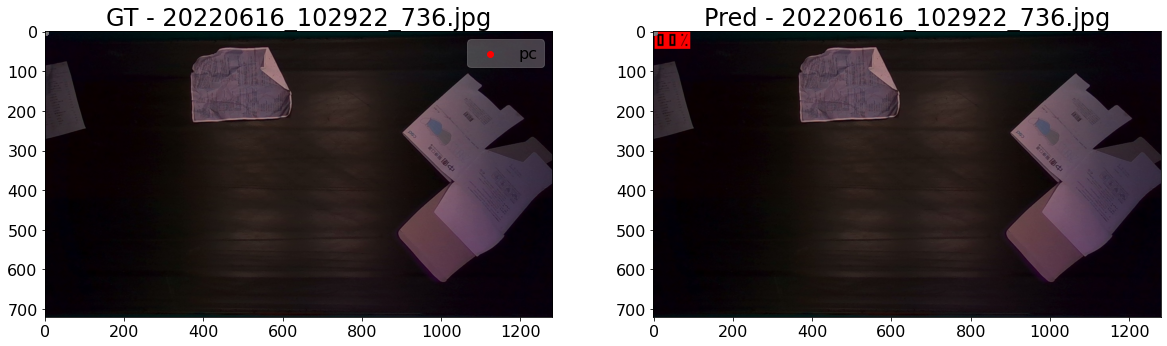

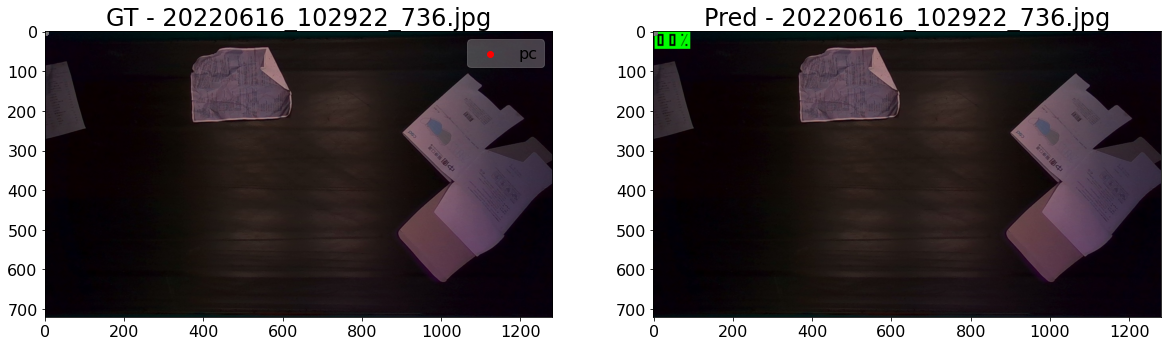

--------------------


In [8]:
!rm ./.tmp.json
obj = EnsemblingCompare("/home/jovyan/data-vol-2/recycling/backboneData/2022-06-16", "../_compare/1108/yolov7_0616_pc", "../_compare/1108/yolov4_0616_pc", \
        classL=['pc'], outputPath="../_compare/1108/compare.json")
json.dump(obj.D, open(".tmp.json","w"))
obj.visPredict("random")

len(self.single1)=615, len(self.single2)=290
sum(self.single1.values())=665, sum(self.single2.values())=296
top5-numOfSingle1: [4, 3, 3, 3, 3]
top5-numOfSingle2: [3, 2, 2, 2, 2]


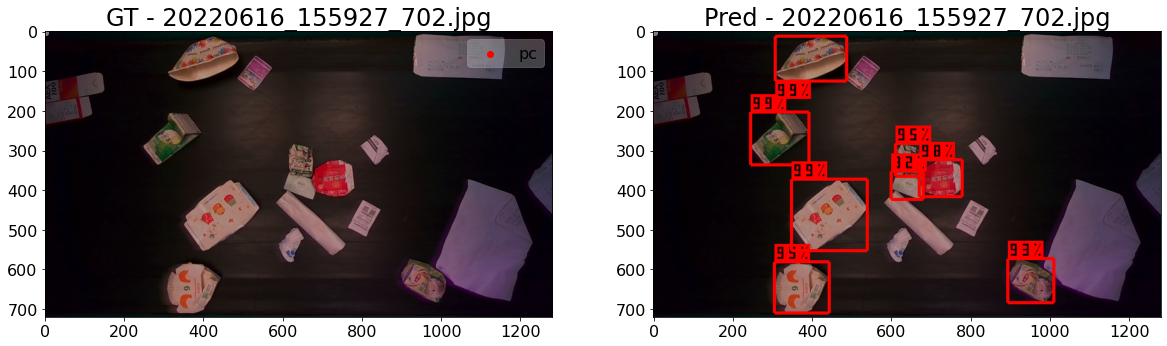

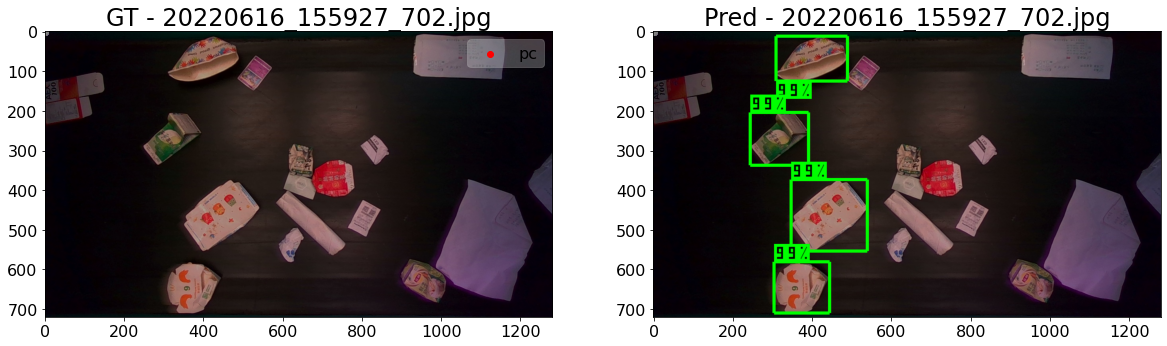

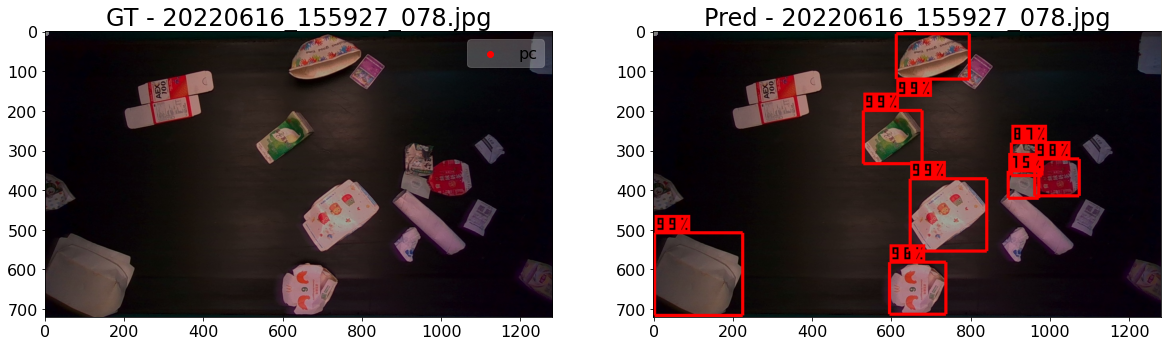

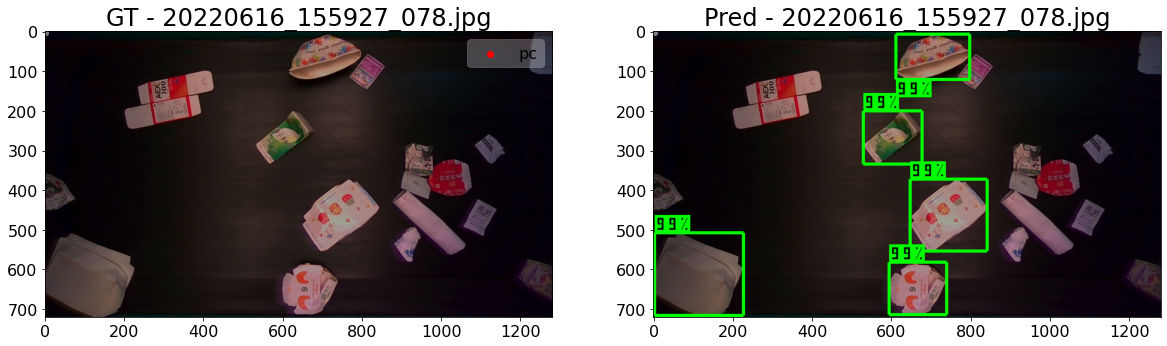

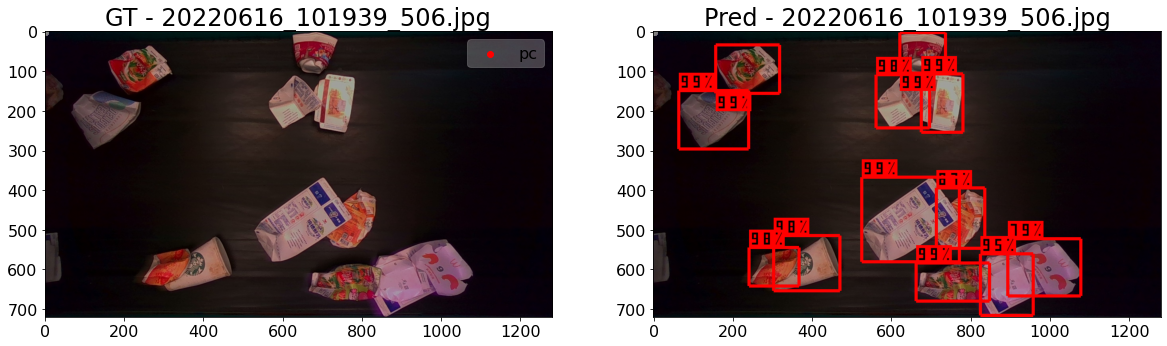

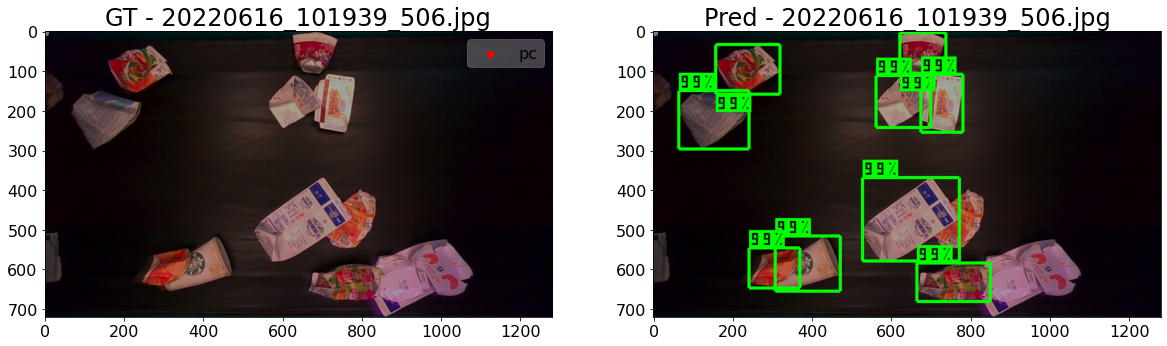

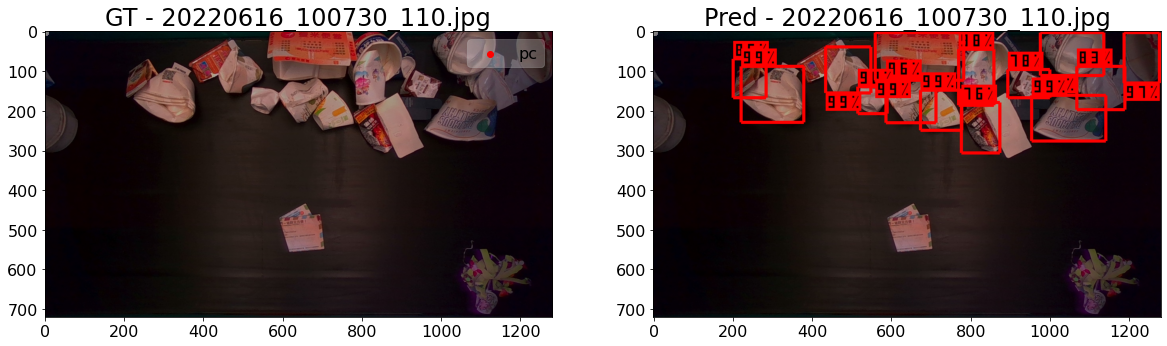

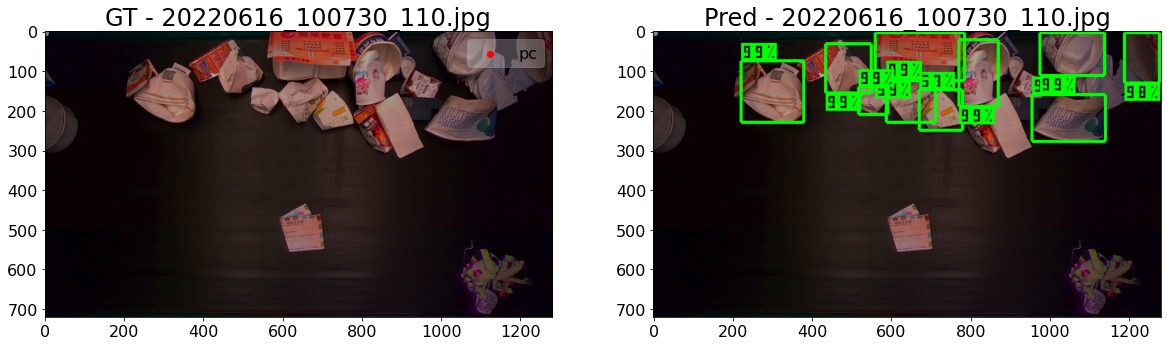

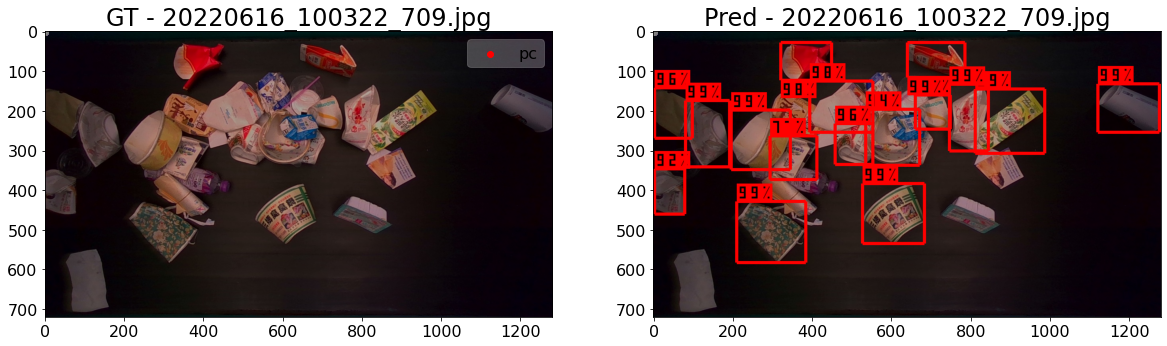

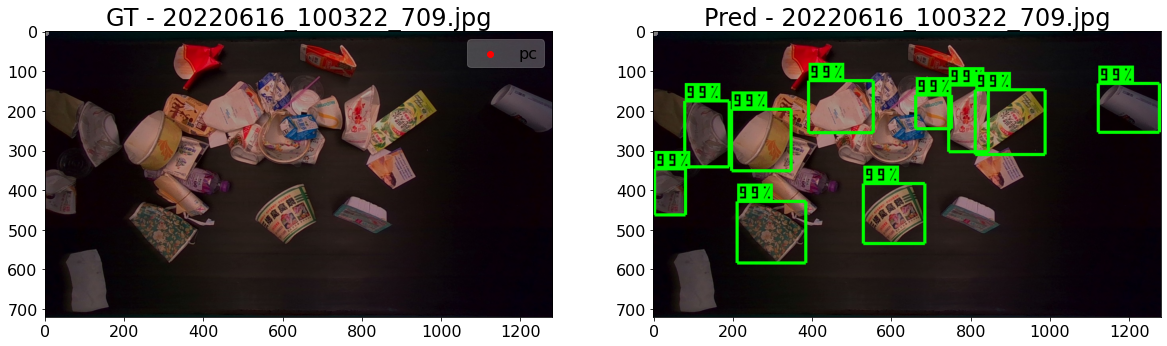

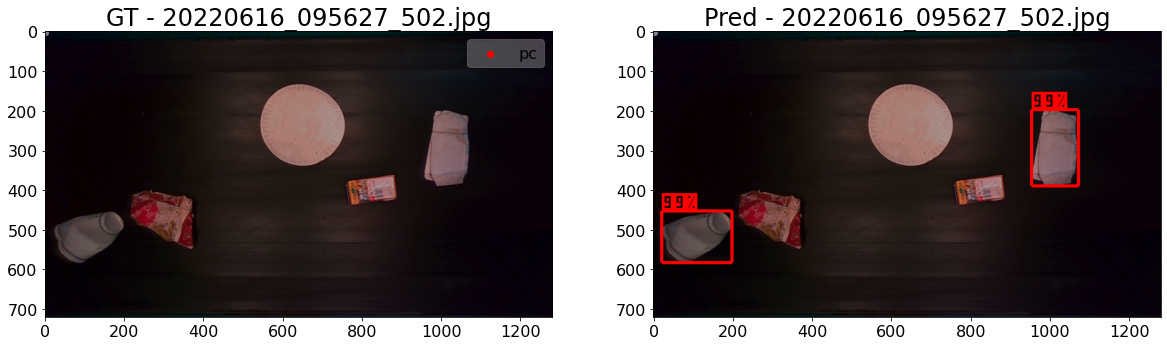

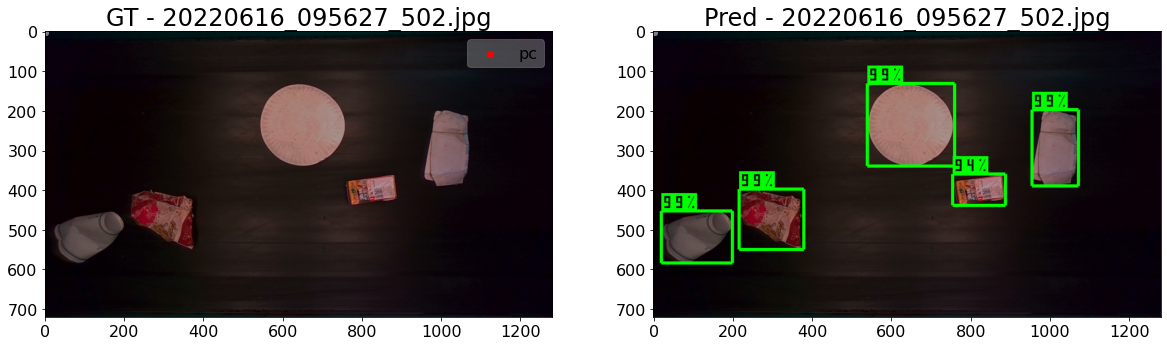

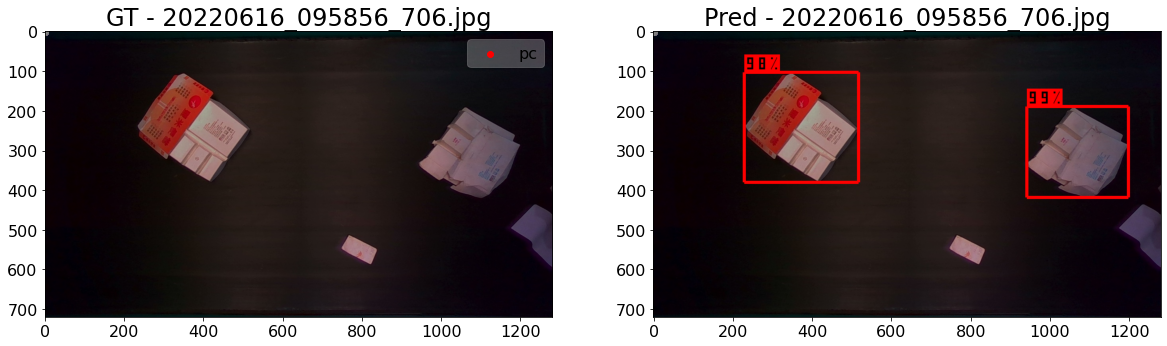

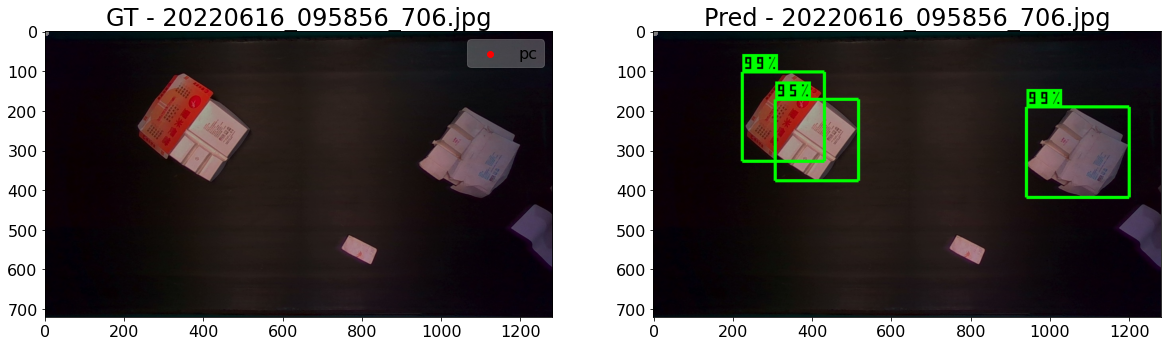

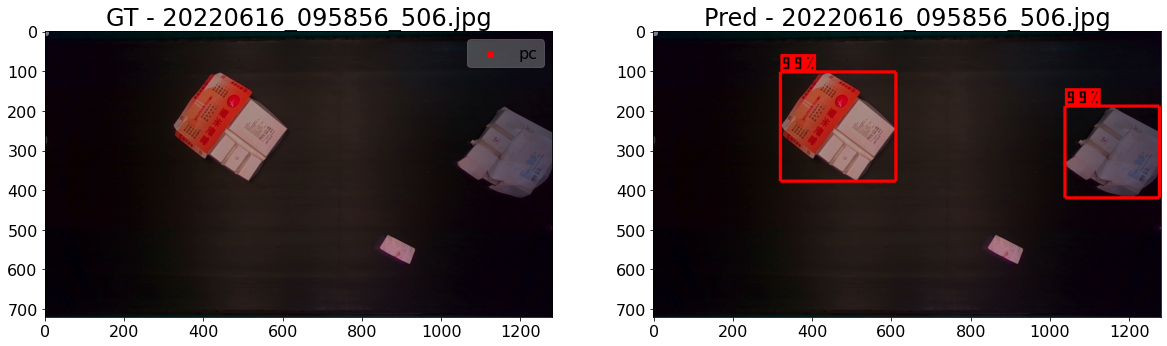

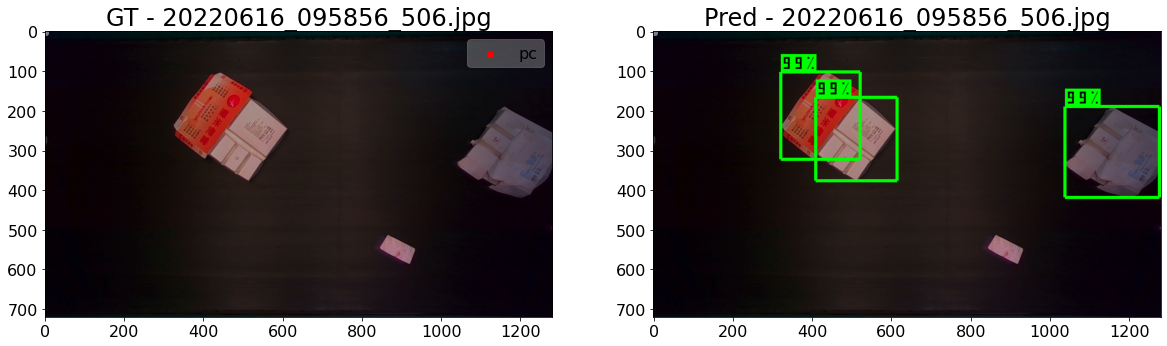

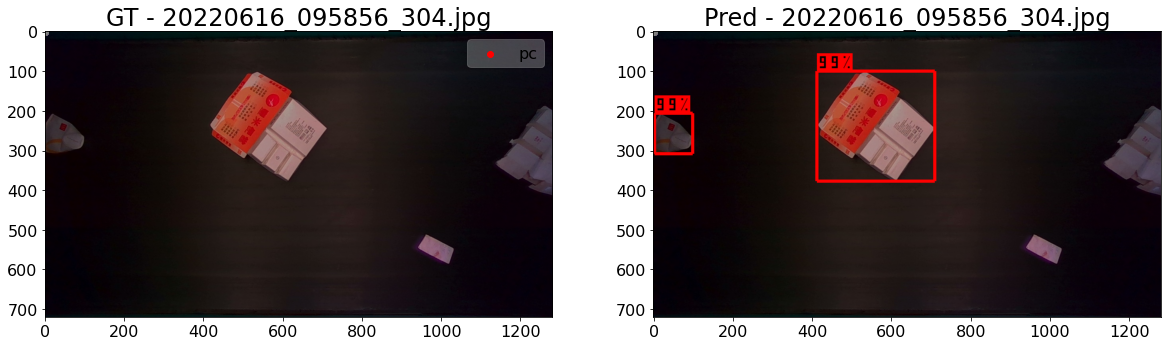

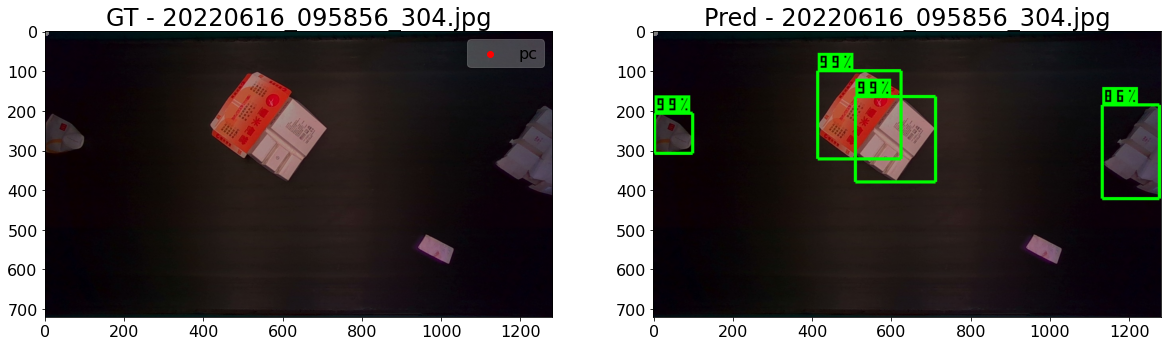

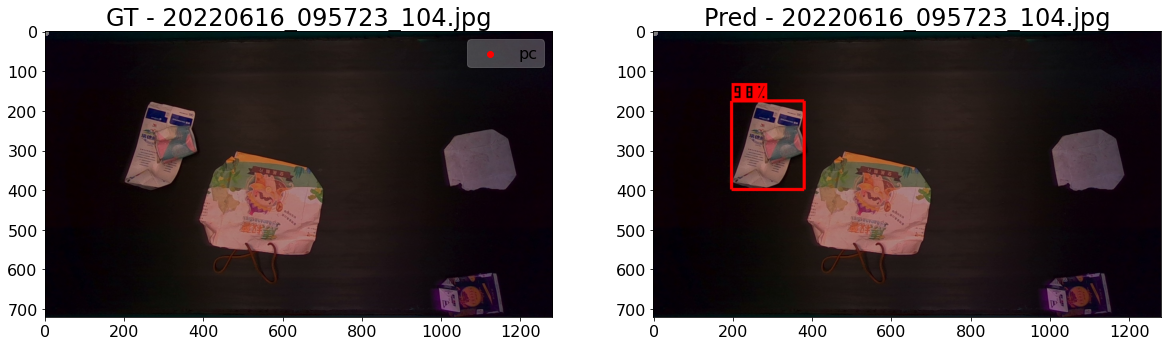

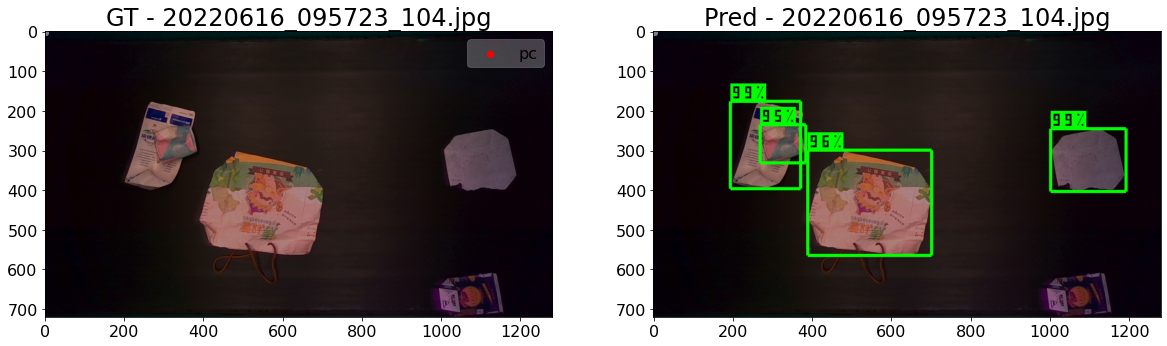

--------------------


In [11]:
obj.matching()
obj.visPredict("sortedSingle", 10)
obj.save()

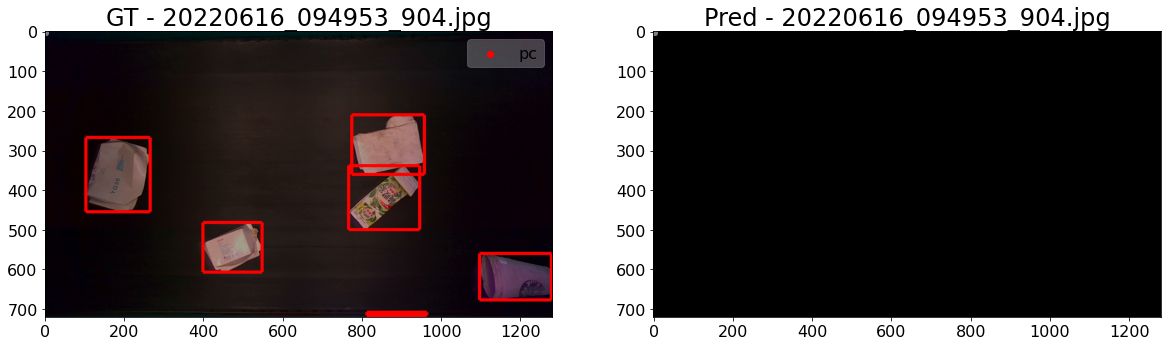

0 0.144043 0.502778 0.125977 0.259722 0.9946062867156329
0 0.369434 0.756771 0.11582 0.173958 0.993618988551757
0 0.668359 0.582639 0.139844 0.223611 0.9927952995735064
0 0.927344 0.859028 0.14375 0.1625 0.9926297214862057
0 0.675781 0.397656 0.142969 0.208854 0.5027741303598033
0 0.693359 0.992014 0.117969 0.015972 0.1542565179875809


In [5]:
vis.show("/home/jovyan/data-vol-2/recycling/backboneData/2022-06-16/20220616_094953_904.jpg", "../_compare/1108/yolov7_0616_pc/20220616_094953_904.txt", classList=['pc'], valueRatios=(1.5,1.5) )
!cat ../_compare/1108/yolov7_0616_pc/20220616_094953_904.txt

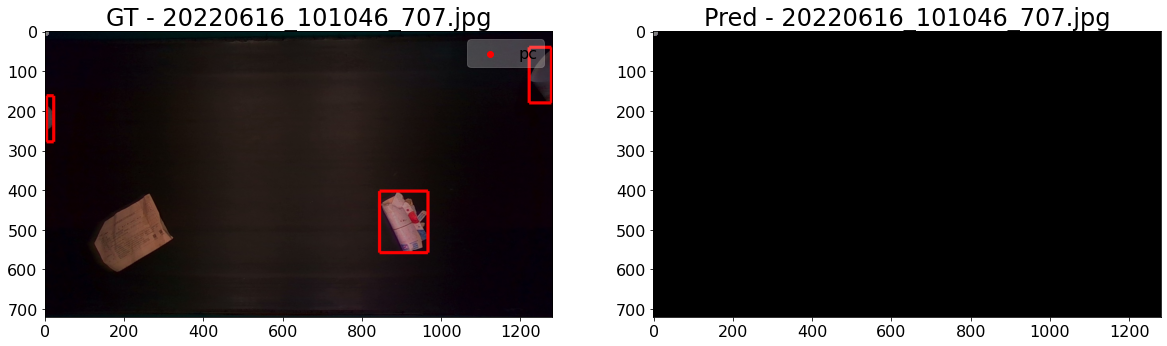

0 0.008691 0.307899 0.017383 0.161979 0.4891126900348596
0 0.707031 0.668056 0.095312 0.215278 0.48238034250856904
0 0.976953 0.154818 0.046094 0.195225 0.12030103183366671


In [6]:
vis.show("/home/jovyan/data-vol-2/recycling/backboneData/2022-06-16/20220616_101046_707.jpg", "../_compare/1108/yolov7_0616_pc/20220616_101046_707.txt", classList=['pc'], valueRatios=(1.5,1.5) )
!cat ../_compare/1108/yolov7_0616_pc/20220616_101046_707.txt